In [2]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import statsmodels.api as sm
import datetime
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
import math
import numpy as np
from statsmodels.tsa.arima_model import ARMA

/home/lechuza/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
base_currency = 'BTC'
#argument needs to be in the form of a string
def get450Day(ticker):
        ''' Acquire historical prices from CRYPTOCOMPARE '''
        url='https://min-api.cryptocompare.com/data/histoday'
        #will return a str
#prices from last 200 days
        parameters= {'fsym':ticker, 'tsym': base_currency, 'e': 'Bittrex', 'aggregate':1,'limit':450}
        
        r=requests.get(url,parameters)
        #handle this error in the calling class
        j_obj=r.json()
        if j_obj['Response']=='Error':
            print(j_obj)
            #print("fetch didn't work")
            raise RuntimeError
        raw_time=j_obj['Data']
        df=pd.DataFrame.from_dict(raw_time)
        df['time']=df['time'].apply(lambda x: datetime.datetime.fromtimestamp(x))
        df.index=pd.to_datetime(df.time)
        return(df)

In [4]:
mro_df=get450Day('XMR')
mro_df['returns']=mro_df['low'].pct_change()
autocorrelation=mro_df['returns'].autocorr()

Nominal prices likely follow a random walk. The one day differentials will be white noise. A random walk is additive.
$P_{t}=\mu + P_{t-1} +\epsilon$.
We can choose to fit an ARMA model and check for the coefficient: If testing for price, its needs to be near 1, if fitting the model on differences, including returns, look for a 0 coefficient.

Apply an augmented Dickey Fuller to determine whether there are any unit roots in the series, ie any departures from stationarity. The null hypothesis is the presence of a unit root. P-values below a selected threshold will allow us to reject the null and conculde stationarity. The adfuller() function does not take any parameters... the defaults are the most practical. You cannot enter a lag... that is done automatically across several lags.

In [5]:
results=adfuller(mro_df['low'])
results[1]

0.23093359402850838

Very high p-value... cannot reject the null that there is a unit root in the series and therefore we can conclude that the untreated series is not stationary. If we prematurely apply an AR1 model we get the below.

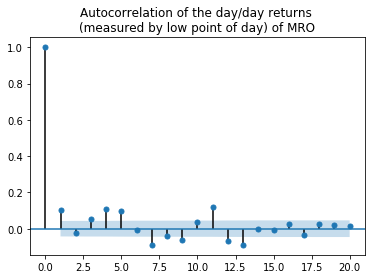

In [6]:
mro_diff=mro_df['low'].pct_change().dropna()
plot_acf(mro_diff,lags=20,alpha=0.5)
plt.title('Autocorrelation of the day/day returns \n(measured by low point of day) of MRO')
plt.show()

Due to some significant autorcorrelation at several steps, we expect a lack of stationarity. Observable above is the oscillating nature of the autocorrelation. This is not correct! We can simulate stationary data, like white noise and observe some quasi significant autocorrelations... they are not reliable. Autocorrelation doesn't cause non-stationarity. Non-stationarity doesn't require autocorrelation. 

Compare this autororrelation plot to one fit onto pure white noise, which is stationary.

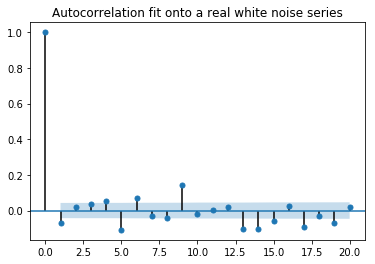

In [7]:
plt.close()
norms=np.random.normal(loc=.001,scale=.01,size=250)
plot_acf(norms,lags=20,alpha=0.5)
plt.title('Autocorrelation fit onto a real white noise series')
plt.show()

### Estimating an AR(1) model

                              ARMA Model Results                              
Dep. Variable:                    low   No. Observations:                  251
Model:                     ARMA(1, 0)   Log Likelihood                1330.640
Method:                       css-mle   S.D. of innovations              0.001
Date:                Wed, 18 Apr 2018   AIC                          -2655.280
Time:                        22:43:12   BIC                          -2644.704
Sample:                    08-11-2017   HQIC                         -2651.024
                         - 04-18-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0214      0.003      7.067      0.000       0.015       0.027
ar.L1.low      0.9785      0.013     75.444      0.000       0.953       1.004
                                    Roots           

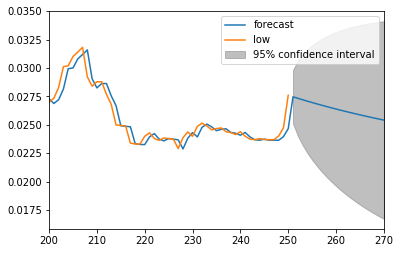

In [8]:
#fit the model on the untreated prices
mod=ARMA(mro_df['low'],order=(1,0))
res=mod.fit()
print(res.summary())
res.plot_predict(start=200, end=270)
plt.show()

Note that the coeficcient is high, but not over 1. This implies a trending or momentum behavior. Additionally, being so close to 1 implies a random walk behavior.

To only view the parameters of the fitted AR model, can call {{res.params}}

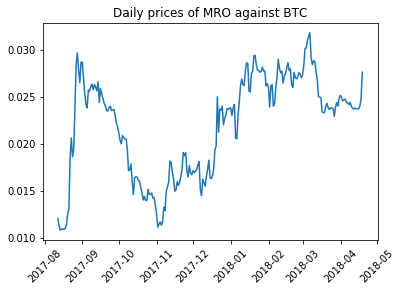

In [9]:
plt.close()
plt.plot(mro_df['low'])
plt.title('Daily prices of MRO against BTC')
#plt.xticks(mro_df['returns'].index.values)
plt.xticks(rotation=45)
plt.show()

In [10]:
plt.close()
plt.plot(mro_df['returns'])
plt.legen('Daily Returns of MRO')
#plt.xticks(mro_df['returns'].index.values)
plt.xticks(rotation=45)
plt.show()

AttributeError: module 'matplotlib.pyplot' has no attribute 'legen'

In [ ]:
plot_acf(mro_df['returns'][1:],lags=20,alpha=.05)
plt.title('Autocorrelation on daily returns - low of the day as unit')
plt.show()

On the above we see the inclusion of confidence intervals around the autocorrelation calculations. Confidence intervals are the bands above and below zero where a statistically significant divergence from 0 cannot be claimed at 95% confidence. This mechanism makes use of the standard normal distribution and calculates the variance with 0 at the mean - 95% of the spread of distribution is contained within 1.96 times the standard deviation. The standard deviation is calculated as 1/sqrt(N)... N = # of observations. What would be interesting is to extract the confidence bands from the plot_acf function to see if the standard deviation and subsequently the N changes with the differing number of observations.